# Setup

In [1]:
import sys
sys.path.insert(
    0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

In [2]:
import sys
sys.path.insert(0, '/home/563/esh563/TINT')

In [3]:
# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import caine_func as caf
import analysis

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF
%aimport tint.process_ACCESS

%pdb


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

Automatic pdb calling has been turned ON


In [4]:
base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

In [5]:
base_dir = '/g/data/hj10/cpol/cpol_level_1b/v2020/gridded/grid_150km_2500m/'
save_dir = '/home/563/esh563/TINT_tracks/'
fig_dir = '/home/563/esh563/TINT_figures/'
ERA5_dir = '/g/data/rt52/era5/pressure-levels/reanalysis/'

# Create Tracks

In [5]:
b_path = '/home/student.unimelb.edu.au/shorte1/Documents/'
b_path += 'CPOL_analysis/circ_b_ind_set.pkl'
with open(b_path, 'rb') as f:
    b_ind_set = pickle.load(f)

In [7]:
topog_files = open('topog_files.txt', 'r')
topog_files = topog_files.read().split('\n')[:-1]
u_files = open('u_files.txt', 'r')
u_files = u_files.read().split('\n')[:-1]
v_files = open('v_files.txt', 'r')
v_files = v_files.read().split('\n')[:-1]
maxcol_refl_files = open('maxcol_refl_files.txt', 'r')
maxcol_refl_files = maxcol_refl_files.read().split('\n')[:-1]
radar_refl_1km_files = open('radar_refl_1km_files.txt', 'r')
radar_refl_1km_files = radar_refl_1km_files.read().split('\n')[:-1]

files_list = [
    topog_files, u_files, v_files, maxcol_refl_files, radar_refl_1km_files]

dates_list = []
for files in files_list:

    dates = [f.split('/')[7] for f in files]
    dates = [
        np.datetime64('{}-{}-{}'.format(f[:4], f[4:6], f[6:8])) 
        for f in dates]
    dates_list.append(set(dates))
    
[topog_dates, u_dates, v_dates, maxcol_refl_dates, radar_refl_1km_dates] = dates_list

In [8]:
files_63 = open('files_63.txt', 'r')
files_63 = files_63.read().split('\n')[:-1]
files_77 = open('files_77.txt', 'r')
files_77 = files_77.read().split('\n')[:-1]
files_42 = open('files_42.txt', 'r')
files_42 = files_42.read().split('\n')[:-1]

files_list = [
    files_63, files_77, files_42]

dates_list = []
for files in files_list:

    dates = [f.split('/')[9].split('_')[1] for f in files]
    dates = [
        np.datetime64('{}-{}-{}'.format(f[:4], f[4:6], f[6:8])) 
        for f in dates]
    dates_list.append(set(dates))
    
[dates_63, dates_77, dates_42] = dates_list

In [9]:
start = np.datetime64('2020-10-01T00:00:00')
end = np.datetime64('2021-05-01T00:00:00')
datetimes_a = np.arange(start, end, np.timedelta64(10,'m'))

In [10]:
start = np.datetime64('2021-10-01T00:00:00')
end = np.datetime64('2022-05-01T00:00:00')
datetimes_b = np.arange(start, end, np.timedelta64(10,'m'))

In [11]:
datetimes = np.concatenate([datetimes_a, datetimes_b])

In [20]:
start = np.datetime64('2020-12-01T00:00:00')
end = np.datetime64('2020-12-02T00:00:00')
datetimes = np.arange(start, end, np.timedelta64(10,'m'))

In [15]:
common_dates = []
membership = []

dates_int = maxcol_refl_dates.intersection(
    radar_refl_1km_dates, dates_63, dates_42, dates_77)

G3_int = u_dates.intersection(v_dates)

for dt in datetimes:
    # Remember we use the previous day's reflectivity at 1200 
    date = np.datetime64(str(dt)[0:10])
    current_date = np.datetime64(str(dt)[0:10])
    hour = int(str(dt)[11:13])
    hour_round = (hour // 6) * 6
    date_hour = current_date + np.timedelta64(hour_round, 'h')
#     import pdb; pdb.set_trace()
    date_cond = date in dates_int
    hour_cond = (
        (date_hour in G3_int)
        and (date_hour + np.timedelta64(6, 'h') in G3_int))
    if date_cond:
        common_dates.append(dt)
        membership.append(1)
    else:
        membership.append(0)

In [22]:
np.datetime64('2021-03-31T00:00') in common_dates

True

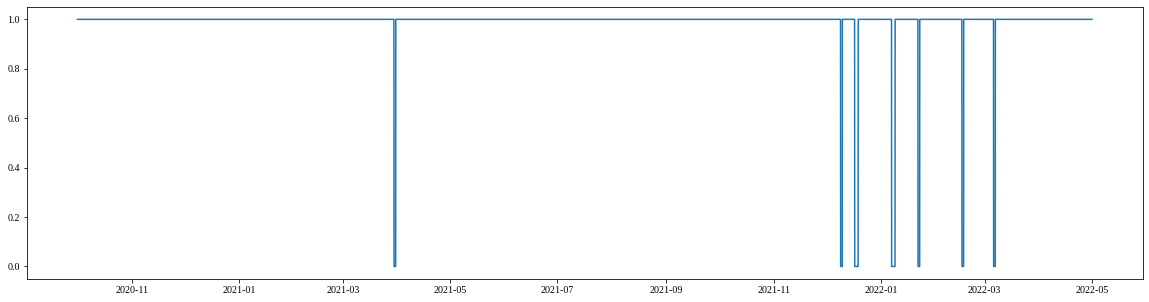

In [19]:
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'mathtext.fontset': 'dejavuserif'})
rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(datetimes, membership)

In [8]:
start = np.datetime64('2021-10-01T00:00:00')
end = np.datetime64('2022-05-01T00:00:00')
datetimes = np.arange(start, end, np.timedelta64(10,'m'))
datetimes = sorted([d for d in datetimes if d in common_times])
datetimes[-10:]

[numpy.datetime64('2022-04-30T22:20:00'),
 numpy.datetime64('2022-04-30T22:30:00'),
 numpy.datetime64('2022-04-30T22:40:00'),
 numpy.datetime64('2022-04-30T22:50:00'),
 numpy.datetime64('2022-04-30T23:00:00'),
 numpy.datetime64('2022-04-30T23:10:00'),
 numpy.datetime64('2022-04-30T23:20:00'),
 numpy.datetime64('2022-04-30T23:30:00'),
 numpy.datetime64('2022-04-30T23:40:00'),
 numpy.datetime64('2022-04-30T23:50:00')]

In [20]:
date_strings = list(np.array(common_dates).astype(str))
np.savetxt(
    'radar_common_times.csv', date_strings, delimiter =", ", fmt ='% s')

In [6]:
common_times = np.loadtxt(
    'ACCESS_radar_common_times.csv', dtype=str).astype(np.datetime64)

In [9]:
# start = np.datetime64('2021-12-21T00:00:00')
# end = np.datetime64('2021-12-25T00:00:00')
# datetimes = np.arange(start, end, np.timedelta64(10,'m'))
# datetimes = np.array(common_dates)

micro_physics = 'ACCESS'

tracks_obj  = tint.Tracks(params={
    'AMBIENT': 'ACCESS', 'AMBIENT_BASE_DIR': None,
    'GS_ALT': 0,
    'LEVELS': np.array(
        [[0, 0.5], [1, 1.5]]),
    'WIND_LEVELS': np.array(
        [[500, 3500], [500, 20000]]),
    'FIELD_THRESH': ['convective', 15],
    'MIN_SIZE': [80, 800],
    'ISO_THRESH': [10, 10],
    'INPUT_TYPE': 'ACCESS_DATETIMES',
    'SAVE_DIR': save_dir,
    'REFERENCE_GRID_FORMAT': 'ODIM',
    'RESET_NEW_DAY': True,
    'REFERENCE_RADAR': 42})

grids = (
    date for date in datetimes)

tracks_obj.get_tracks(grids, b_path=b_path)

Creating a reference grid.
Interpolating ACCESS-C reflectivity at 2021-10-01T00:00:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
Getting ACCESS-G ambient winds at 2021-10-01T00:00:00.000000.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 0.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7.
Updating ACCESS-C pseudo pyart reflectivity grid.


/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/numba/core/consts.py:114: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return getattr(value, expr.attr)
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/numba/core/ir_utils.py:2097: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int

No objects found in scan 8.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20.
Updating ACCESS-C pseudo 

Getting ACCESS-G ambient winds at 2021-10-01T21:10:00.000000.
Writing tracks for scan 127.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 128.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 129.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 130.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 131.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 132.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 133.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 134.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 135.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 136.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 137.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 138.
Updating ACCESS-C pseudo pyart reflectiv

No objects found in scan 248.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 249.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 250.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 251.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 252.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 253.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 254.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 255.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 256.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 257.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 258.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 259.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 260.
Updating A

No objects found in scan 372.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 373.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 374.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 375.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 376.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 377.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 378.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 379.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 380.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 381.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 382.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 383.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 384.
Updating A

Getting ACCESS-G ambient winds at 2021-10-04T08:20:00.000000.
Writing tracks for scan 482.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 483.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 484.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 485.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 486.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 487.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 488.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 489.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 490.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 491.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 492.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 493.
Updating ACCESS-C pseudo pyart refle

No objects found in scan 602.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 603.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 604.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 605.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 606.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 607.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 608.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 609.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 610.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 611.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 612.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 613.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 614.
Updating A

Interpolating ACCESS-C reflectivity at 2021-10-06T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-10-06. Resetting objects.
No objects found in scan 720.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 721.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 722.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 723.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 724.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 725.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 726.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 727.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 728.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 729.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 730.
Updating ACCESS-C 

No objects found in scan 822.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 823.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 824.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 825.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 826.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 827.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 828.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 829.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 830.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 831.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 832.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 833.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 834.
Updating A

Getting ACCESS-G ambient winds at 2021-10-07T11:00:00.000000.
Writing tracks for scan 930.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 931.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 932.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 933.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 934.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 935.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 936.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-10-07T12:10:00.000000.
Getting ACCESS-G ambient winds at 2021-10-07T12:10:00.000000.
Writing tracks for scan 937.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 938.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 939.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in s

Getting ACCESS-G ambient winds at 2021-10-08T03:40:00.000000.
Writing tracks for scan 1030.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1031.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1032.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1033.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1034.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1035.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1036.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1037.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1038.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1039.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1040.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1041.
Updating ACCESS-C 

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1150.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 1151 last before new day.
Interpolating ACCESS-C reflectivity at 2021-10-09T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-10-09. Resetting objects.
No objects found in scan 1152.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1153.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1154.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1155.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1156.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1157.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1158.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1159.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1160.
Updatin

No objects found in scan 1289.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1290.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1291.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1292.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1293.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1294.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 1295 last before new day.
Interpolating ACCESS-C reflectivity at 2021-10-10T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-10-10. Resetting objects.
No objects found in scan 1296.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1297.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1298.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1299.
Updating ACCESS-C pseudo pyart reflectivity grid.
No obje

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1416.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1417.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1418.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1419.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1420.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1421.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1422.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1423.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1424.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1425.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1426.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1427.
Updating ACCESS-C pseudo pya

Getting ACCESS-G ambient winds at 2021-10-11T12:00:00.000000.
Writing tracks for scan 1512.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1513.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1514.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1515.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1516.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1517.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1518.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1519.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1520.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1521.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1522.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1523.
Updating ACCESS-C ps

No objects found in scan 1623.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1624.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1625.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1626.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1627.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1628.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1629.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1630.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1631.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1632.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1633.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1634.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 163

Interpolating ACCESS-C reflectivity at 2021-10-13T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-10-13. Resetting objects.
No objects found in scan 1728.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1729.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1730.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1731.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1732.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1733.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1734.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1735.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1736.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1737.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1738.
Updatin

Writing tracks for scan 1825.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1826.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1827.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1828.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1829.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1830.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1831.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1832.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1833.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1834.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1835.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-10-13T18:00:00.000000.
Getting ACCESS-G ambient winds at 2021-10-13T18:00:00.00

Writing tracks for scan 1923.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1924.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1925.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1926.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1927.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1928.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1929.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1930.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1931.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1932.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1933.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1934.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1935.
Updating A

No objects found in scan 2047.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2048.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2049.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2050.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2051.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2052.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2053.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2054.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2055.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2056.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2057.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2058.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 205

Interpolating ACCESS-C reflectivity at 2021-10-16T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-10-16. Resetting objects.
No objects found in scan 2160.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2161.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2162.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2163.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2164.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2165.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2166.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2167.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2168.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2169.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2170.
Updatin

Writing tracks for scan 2259.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2260.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2261.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2262.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2263.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2264.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2265.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2266.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2267.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2268.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2269.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2270.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2271.
Upda

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2358.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2359.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2360.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2361.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2362.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2363.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2364.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2365.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2366.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2367.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2368.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2369.
Updating ACCESS-C pseudo pyart reflectiv

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2476.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2477.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2478.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2479.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2480.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2481.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2482.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2483.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2484.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2485.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2486.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2487.
Updating ACCESS-C pseudo pya

Interpolating ACCESS-C reflectivity at 2021-10-19T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-10-19. Resetting objects.
No objects found in scan 2592.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2593.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2594.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2595.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2596.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2597.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2598.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2599.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2600.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2601.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2602.
Updatin

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2712.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2713.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2714.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2715.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2716.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2717.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2718.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2719.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2720.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2721.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2722.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2723.
Updating ACCESS-C pseudo pya

No objects found in scan 2828.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2829.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2830.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2831.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2832.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2833.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2834.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2835.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2836.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2837.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2838.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2839.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 284

Writing tracks for scan 2928.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2929.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2930.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2931.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2932.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2933.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2934.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2935.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2936.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2937.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2938.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2939.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2940.
Updating A

Getting ACCESS-G ambient winds at 2021-10-22T03:30:00.000000.
Writing tracks for scan 3045.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3046.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3047.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3048.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3049.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3050.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3051.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3052.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3053.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3054.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3055.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3056.
Updating ACCESS-C pseudo pya

Interpolating ACCESS-C reflectivity at 2021-10-23T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-10-23. Resetting objects.
No objects found in scan 3168.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3169.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3170.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3171.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3172.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3173.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3174.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3175.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3176.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3177.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3178.
Updatin

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3294.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3295.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3296.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3297.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3298.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3299.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3300.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3301.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3302.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3303.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3304.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3305.
Updating ACCESS-C pseudo pya

No objects found in scan 3405.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3406.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3407.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3408.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3409.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3410.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3411.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3412.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3413.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3414.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3415.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3416.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 341

Writing tracks for scan 3503.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3504.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3505.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3506.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3507.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3508.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3509.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3510.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3511.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3512.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3513.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3514.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3515.
Updating A

Getting ACCESS-G ambient winds at 2021-10-26T02:50:00.000000.
Writing tracks for scan 3617.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3618.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3619.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3620.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3621.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3622.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3623.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3624.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3625.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3626.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3627.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3628.
Updating ACCESS-C p

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3717.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3718.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3719.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3720.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3721.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3722.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3723.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3724.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3725.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3726.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3727.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3728.
Updating ACCESS-C pseudo pya

Getting ACCESS-G ambient winds at 2021-10-27T12:00:00.000000.
Writing tracks for scan 3816.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3817.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3818.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3819.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3820.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3821.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3822.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3823.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3824.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3825.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3826.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3827.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3914.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3915.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3916.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3917.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3918.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3919.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3920.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3921.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3922.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3923.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-10-28T06:00:00.000000.
Getting ACCESS-G ambient winds at 2021-10-28T06:00:00.000000.
Writing tracks for scan 3

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4030.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 4031 last before new day.
Interpolating ACCESS-C reflectivity at 2021-10-29T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-10-29. Resetting objects.
No objects found in scan 4032.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4033.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4034.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4035.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4036.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4037.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4038.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4039.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4040.
Updatin

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4147.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4148.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4149.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4150.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4151.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4152.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4153.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4154.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4155.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4156.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4157.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4158.
Updating ACCESS-C pseudo pya

No objects found in scan 4250.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4251.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4252.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4253.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4254.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4255.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4256.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4257.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4258.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4259.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4260.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4261.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 426

Writing tracks for scan 4349.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4350.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4351.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4352.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4353.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4354.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4355.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-10-31T06:00:00.000000.
Getting ACCESS-G ambient winds at 2021-10-31T06:00:00.000000.
Writing tracks for scan 4356.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4357.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4358.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4359.
Updating ACCESS-C pseudo pyart reflectivity g

Interpolating ACCESS-C reflectivity at 2021-11-01T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-11-01. Resetting objects.
No objects found in scan 4464.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4465.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4466.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4467.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4468.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4469.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4470.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4471.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4472.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4473.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4474.
Updatin

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4575.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4576.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4577.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4578.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4579.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4580.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4581.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4582.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4583.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4584.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4585.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4586.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4706.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4707.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4708.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4709.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4710.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4711.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4712.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4713.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4714.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4715.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4716.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4717.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4842.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4843.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4844.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4845.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4846.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4847.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4848.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4849.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4850.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4851.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4852.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4853.
Updating ACCESS-C pseudo pya

No objects found in scan 4943.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4944.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4945.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4946.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4947.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4948.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4949.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4950.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4951.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4952.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4953.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4954.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 495

No objects found in scan 5063.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5064.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5065.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5066.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5067.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5068.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5069.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5070.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5071.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5072.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5073.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5074.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 507

Interpolating ACCESS-C reflectivity at 2021-11-06T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-11-06. Resetting objects.
No objects found in scan 5184.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5185.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5186.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5187.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5188.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5189.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5190.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5191.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5192.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5193.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5194.
Updatin

Writing tracks for scan 5290.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5291.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-11-06T18:00:00.000000.
Getting ACCESS-G ambient winds at 2021-11-06T18:00:00.000000.
Writing tracks for scan 5292.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5293.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5294.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5295.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5296.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5297.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5298.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5299.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5300.
Updating ACCESS-C pseudo pyart reflectivity g

Writing tracks for scan 5389.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5390.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5391.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5392.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5393.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5394.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5395.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5396.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5397.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5398.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5399.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-11-07T12:00:00.000000.
Getting ACCESS-G ambient winds at 2021-11-07T12:00:00.000

Getting ACCESS-G ambient winds at 2021-11-08T03:10:00.000000.
Writing tracks for scan 5491.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5492.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5493.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5494.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5495.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5496.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5497.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5498.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5499.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5500.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5501.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5502.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5597.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5598.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5599.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5600.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5601.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5602.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5603.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5604.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5605.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5606.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5607.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5608.
Updating ACCESS-C pseudo pyart 

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5701.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5702.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5703.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5704.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5705.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5706.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5707.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5708.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5709.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5710.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5711.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5712.
Updating ACCESS-C pseudo pyart reflectiv

Writing tracks for scan 5798.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5799.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5800.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5801.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5802.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5803.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5804.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5805.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5806.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5807.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5808.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5809.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5810.
Updating A

Interpolating ACCESS-C reflectivity at 2021-11-11T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-11-11. Resetting objects.
No objects found in scan 5904.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-11-11T00:10:00.000000.
Getting ACCESS-G ambient winds at 2021-11-11T00:10:00.000000.
Writing tracks for scan 5905.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5906.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5907.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5908.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5909.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5910.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5911.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5912.
Updating ACCESS-C pseudo pyart reflectivity g

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6013.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6014.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-11-11T18:30:00.000000.
Getting ACCESS-G ambient winds at 2021-11-11T18:30:00.000000.
Writing tracks for scan 6015.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6016.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6017.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6018.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 6019.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 6020.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 6021.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 6022.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for s

No objects found in scan 6122.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6123.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6124.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6125.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6126.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6127.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6128.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6129.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6130.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6131.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6132.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6133.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 613

No objects found in scan 6228.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6229.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6230.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6231.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6232.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6233.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6234.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6235.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6236.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6237.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6238.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6239.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 624

Interpolating ACCESS-C reflectivity at 2021-11-14T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectiv

Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Interpolating ACCESS-C reflectivity at 2021-11-15T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectiv

Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Interpolating ACCESS-C reflectivity at 2021-11-16T00:10:00.
Updating ACCESS

Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Interpolating ACCESS-C reflectivity at 2021-11-17T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectiv

Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Interpolating ACCESS-C reflectivity at 2021-11-18T00:10:00.
Updating ACCESS

Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Interpolating ACCESS-C reflectivity at 2021-11-19T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectiv

Writing tracks for scan 6393.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 6394.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 6395.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 6396.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6397.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6398.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6399.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6400.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6401.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6402.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6403.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6404.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6405.
U

No objects found in scan 6504.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6505.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6506.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6507.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6508.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6509.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6510.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6511.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6512.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6513.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6514.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6515.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 651

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6617.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6618.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6619.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6620.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6621.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6622.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6623.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6624.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6625.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6626.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6627.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6628.
Updating ACCESS-C pseudo pya

Interpolating ACCESS-C reflectivity at 2021-11-22T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-11-22. Resetting objects.
No objects found in scan 6730.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6731.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6732.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6733.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6734.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6735.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6736.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6737.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6738.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6739.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6740.
Updatin

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6854.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6855.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6856.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6857.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6858.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6859.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6860.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6861.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6862.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6863.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6864.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6865.
Updating ACCESS-C pseudo pya

No objects found in scan 6962.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6963.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6964.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6965.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6966.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6967.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6968.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6969.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6970.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6971.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6972.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6973.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 697

Writing tracks for scan 7060.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7061.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7062.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7063.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7064.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7065.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7066.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7067.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7068.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7069.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7070.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7071.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7072.
Updating A

Interpolating ACCESS-C reflectivity at 2021-11-25T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-11-25. Resetting objects.
No objects found in scan 7162.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-11-25T00:10:00.000000.
Getting ACCESS-G ambient winds at 2021-11-25T00:10:00.000000.
Writing tracks for scan 7163.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7164.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7165.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7166.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7167.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7168.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7169.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7170.
Updating ACCESS-C pseudo pyart reflectivity g

Writing tracks for scan 7259.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7260.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7261.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7262.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7263.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7264.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7265.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7266.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7267.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7268.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7269.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-11-25T18:00:00.000000.
Getting ACCESS-G ambient winds at 2021-11-25T18:00:00.000

Writing tracks for scan 7356.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7357.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7358.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7359.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7360.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7361.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7362.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7363.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7364.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7365.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7366.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7367.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7368.
Updating A

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7480.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7481.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7482.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7483.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7484.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7485.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7486.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7487.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7488.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7489.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7490.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7491.
Updating ACCESS-C pseudo pya

Interpolating ACCESS-C reflectivity at 2021-11-28T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-11-28. Resetting objects.
No objects found in scan 7594.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7595.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7596.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7597.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7598.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7599.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7600.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7601.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7602.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7603.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7604.
Updatin

No objects found in scan 7708.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7709.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7710.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7711.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7712.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7713.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7714.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7715.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7716.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7717.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7718.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7719.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 772

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7849.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7850.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7851.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7852.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7853.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7854.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7855.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7856.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7857.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7858.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7859.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7860.
Updating ACCESS-C pseudo pya

No objects found in scan 7961.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7962.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7963.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7964.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7965.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7966.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7967.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7968.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7969.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7970.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7971.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7972.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 797

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8096.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8097.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8098.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8099.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8100.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8101.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8102.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8103.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8104.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8105.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8106.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8107.
Updating ACCESS-C pseudo pya

No objects found in scan 8197.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8198.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8199.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8200.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8201.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8202.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8203.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8204.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8205.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8206.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8207.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8208.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 820

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8305.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8306.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8307.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8308.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8309.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8310.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8311.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8312.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 8313 last before new day.
Interpolating ACCESS-C reflectivity at 2021-12-03T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-12-03. Resetting objects.
No objects found in scan 8314.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8315.
Updatin

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8419.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8420.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8421.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8422.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8423.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8424.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8425.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8426.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8427.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8428.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8429.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8430.
Updating ACCESS-C pseudo pya

Writing tracks for scan 8520.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8521.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8522.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8523.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8524.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8525.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8526.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8527.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8528.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8529.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-12-04T12:00:00.000000.
Getting ACCESS-G ambient winds at 2021-12-04T12:00:00.000000.
Writing tracks for scan 8530.
Updating ACCESS-C pseudo pyart reflectivity g

Getting ACCESS-G ambient winds at 2021-12-05T03:10:00.000000.
Writing tracks for scan 8621.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8622.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8623.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8624.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8625.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8626.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8627.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8628.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8629.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8630.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8631.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8632.
Updating ACCESS-C pseudo pya

No objects found in scan 8741.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8742.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8743.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8744.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 8745 last before new day.
Interpolating ACCESS-C reflectivity at 2021-12-06T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-12-06. Resetting objects.
No objects found in scan 8746.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8747.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8748.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8749.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8750.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8751.
Updating ACCESS-C pseudo pyart reflectivity grid.
No obje

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8861.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8862.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8863.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8864.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8865.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8866.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8867.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8868.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8869.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8870.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8871.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8872.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8977.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8978.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8979.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8980.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8981.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8982.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8983.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8984.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8985.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8986.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8987.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8988.
Updating ACCESS-C pseudo pya

Writing tracks for scan 9076.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9077.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9078.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9079.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9080.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9081.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9082.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9083.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9084.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9085.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9086.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9087.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9088.
Updating

Interpolating ACCESS-C reflectivity at 2021-12-09T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-12-09. Resetting objects.
No objects found in scan 9178.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9179.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9180.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9181.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9182.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9183.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9184.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9185.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9186.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9187.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9188.
Updatin

Writing tracks for scan 9274.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9275.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9276.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9277.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9278.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9279.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9280.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9281.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9282.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9283.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9284.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9285.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9394.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9395.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9396.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9397.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9398.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9399.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9400.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9401.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9402.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9403.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9404.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9405.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9502.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9503.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9504.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9505.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9506.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9507.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9508.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9509.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9510.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9511.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9512.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9513.
Updating ACCESS-C pseudo pya

Interpolating ACCESS-C reflectivity at 2021-12-13T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-12-13. Resetting objects.
No objects found in scan 9610.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9611.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9612.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9613.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9614.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9615.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9616.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9617.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9618.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9619.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9620.
Updatin

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9731.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9732.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9733.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9734.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9735.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9736.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9737.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9738.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9739.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9740.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9741.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9742.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9850.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9851.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9852.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9853.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9854.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9855.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9856.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9857.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9858.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9859.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9860.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9861.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9956.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9957.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9958.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9959.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9960.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9961.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9962.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9963.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9964.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9965.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9966.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9967.
Updating ACCESS-C pseudo pya

Getting ACCESS-G ambient winds at 2021-12-16T04:10:00.000000.
Writing tracks for scan 10067.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10068.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10069.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10070.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10071.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10072.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10073.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10074.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10075.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10076.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10077.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10078.
Updating ACCES

Interpolating ACCESS-C reflectivity at 2021-12-17T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-12-17. Resetting objects.
No objects found in scan 10186.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10187.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10188.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10189.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10190.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10191.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10192.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10193.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10194.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10195.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 101

Writing tracks for scan 10283.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10284.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10285.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10286.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10287.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10288.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10289.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10290.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10291.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10292.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10293.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10294.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan

Writing tracks for scan 10378.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10379.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10380.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10381.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10382.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10383.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10384.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10385.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10386.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10387.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10388.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10389.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1039

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10513.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10514.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10515.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10516.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10517.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10518.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10519.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10520.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10521.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10522.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10523.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10524.
Updating ACCESS-

Interpolating ACCESS-C reflectivity at 2021-12-22T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-12-22. Resetting objects.
No objects found in scan 10618.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10619.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10620.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10621.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10622.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10623.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10624.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10625.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10626.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10627.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 106

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10739.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10740.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10741.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10742.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10743.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10744.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10745.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10746.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10747.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10748.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10749.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10750.
Updating ACCESS-

No objects found in scan 10838.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10839.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10840.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10841.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10842.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10843.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10844.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10845.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10846.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10847.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10848.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10849.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10939.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10940.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10941.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-12-24T06:00:00.000000.
Getting ACCESS-G ambient winds at 2021-12-24T06:00:00.000000.
Writing tracks for scan 10942.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10943.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10944.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10945.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10946.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10947.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10948.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks

Interpolating ACCESS-C reflectivity at 2021-12-25T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-12-25. Resetting objects.
No objects found in scan 11050.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-12-25T00:10:00.000000.
Getting ACCESS-G ambient winds at 2021-12-25T00:10:00.000000.
Writing tracks for scan 11051.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11052.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11053.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11054.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11055.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11056.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11057.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11058.
Updating ACCESS-C pseudo pyart reflectivity

Writing tracks for scan 11146.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11147.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11148.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11149.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11150.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11151.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11152.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11153.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11154.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11155.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11156.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11157.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient wi

Writing tracks for scan 11242.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11243.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11244.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11245.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11246.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11247.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11248.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11249.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11250.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11251.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11252.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11253.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1125

Writing tracks for scan 11339.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11340.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11341.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11342.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11343.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11344.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11345.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11346.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11347.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11348.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11349.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11350.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1135

Writing tracks for scan 11439.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11440.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11441.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11442.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11443.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11444.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11445.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-12-27T18:00:00.000000.
Getting ACCESS-G ambient winds at 2021-12-27T18:00:00.000000.
Writing tracks for scan 11446.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11447.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11448.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11449.
Updating ACCESS-C pseudo pyart ref

Writing tracks for scan 11535.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11536.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11537.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11538.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11539.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11540.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11541.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11542.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11543.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11544.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11545.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11546.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 

Getting ACCESS-G ambient winds at 2021-12-29T05:10:00.000000.
Writing tracks for scan 11657.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11658.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11659.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11660.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11661.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-12-29T06:00:00.000000.
Getting ACCESS-G ambient winds at 2021-12-29T06:00:00.000000.
Writing tracks for scan 11662.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11663.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11664.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11665.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11666.
Updating ACCESS-C pseudo pyart reflectivity grid.

Interpolating ACCESS-C reflectivity at 2021-12-30T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectiv

No objects found in scan 11785.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11786.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11787.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11788.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11789.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11790.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11791.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11792.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11793.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11794.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11795.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11796.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11892.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11893.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11894.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11895.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11896.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11897.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11898.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11899.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11900.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11901.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11902.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11903.
Updating ACCESS-

No objects found in scan 11997.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11998.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11999.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12000.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12001.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12002.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12003.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12004.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12005.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12006.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12007.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12008.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Interpolating ACCESS-C reflectivity at 2022-01-02T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-01-02. Resetting objects.
No objects found in scan 12105.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12106.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12107.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12108.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12109.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12110.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12111.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12112.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12113.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12114.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 121

No objects found in scan 12216.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12217.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12218.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12219.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12220.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12221.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12222.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12223.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12224.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12225.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12226.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12227.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12313.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12314.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12315.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12316.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12317.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12318.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12319.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12320.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-01-03T12:00:00.000000.
Getting ACCESS-G ambient winds at 2022-01-03T12:00:00.000000.
Writing tracks for scan 12321.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12322.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks 

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12435.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12436.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12437.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12438.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12439.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12440.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12441.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12442.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12443.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12444.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12445.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12446.
Updating ACCESS-

Interpolating ACCESS-C reflectivity at 2022-01-05T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-01-05. Resetting objects.
No objects found in scan 12537.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12538.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12539.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12540.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12541.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12542.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12543.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12544.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12545.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12546.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 125

Writing tracks for scan 12632.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12633.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12634.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12635.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12636.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12637.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12638.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12639.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12640.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12641.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12642.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12643.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1264

Writing tracks for scan 12728.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12729.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12730.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12731.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12732.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12733.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12734.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12735.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12736.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12737.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12738.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12739.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1274

Getting ACCESS-G ambient winds at 2022-01-07T04:50:00.000000.
Writing tracks for scan 12854.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12855.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12856.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12857.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12858.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12859.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12860.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-01-07T06:00:00.000000.
Getting ACCESS-G ambient winds at 2022-01-07T06:00:00.000000.
Writing tracks for scan 12861.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12862.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12863.
Updating ACCESS-C pseudo pyart reflectivity grid.
Wri

Interpolating ACCESS-C reflectivity at 2022-01-10T00:00:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 12965 last before new day.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-01-10. Resetting objects.
No objects found in scan 12966.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12967.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12968.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12969.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12970.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12971.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12972.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12973.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12974.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 129

No objects found in scan 13062.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13063.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13064.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13065.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13066.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13067.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13068.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13069.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13070.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13071.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13072.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13073.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 13186.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13187.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13188.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13189.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13190.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13191.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13192.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13193.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13194.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13195.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13196.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-01-11T14:30:00.000000.
Getting ACCESS-G ambient winds at 2

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13281.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13282.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13283.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13284.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13285.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13286.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13287.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13288.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-01-12T06:00:00.000000.
Getting ACCESS-G ambient winds at 2022-01-12T06:00:00.000000.
Writing tracks for scan 13289.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13290.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks 

Writing tracks for scan 13378.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13379.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13380.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13381.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13382.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13383.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13384.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13385.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13386.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13387.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13388.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13389.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1339

Writing tracks for scan 13474.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13475.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13476.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13477.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13478.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13479.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13480.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13481.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13482.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13483.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13484.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13485.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1348

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13571.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13572.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13573.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-01-14T06:00:00.000000.
Getting ACCESS-G ambient winds at 2022-01-14T06:00:00.000000.
Writing tracks for scan 13574.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13575.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13576.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13577.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13578.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13579.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13580.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks 

Writing tracks for scan 13670.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13671.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13672.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13673.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13674.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13675.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13676.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13677.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13678.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13679.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13680.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 13681 last before new day.
Interpolating ACCESS-C reflectivity at 2022-01-15T00:10:00.
Updating ACCESS-

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13802.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13803.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13804.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13805.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13806.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13807.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13808.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13809.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13810.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13811.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13812.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13813.
Updating ACCESS-

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13901.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13902.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13903.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13904.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13905.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13906.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13907.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13908.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13909.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13910.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13911.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13912.
Updating ACCESS-C pseu

Writing tracks for scan 13998.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13999.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14000.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14001.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14002.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14003.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14004.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-01-17T06:00:00.000000.
Getting ACCESS-G ambient winds at 2022-01-17T06:00:00.000000.
Writing tracks for scan 14005.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14006.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14007.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14008.
Updating ACCESS-C pseudo pyart ref

Interpolating ACCESS-C reflectivity at 2022-01-18T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-01-18. Resetting objects.
No objects found in scan 14113.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14114.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14115.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14116.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14117.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14118.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14119.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14120.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14121.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14122.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 141

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14248.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14249.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14250.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14251.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14252.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14253.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14254.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14255.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 14256 last before new day.
Interpolating ACCESS-C reflectivity at 2022-01-19T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-01-19. Resetting objects.
No objects found in scan 14257.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 142

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14373.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14374.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14375.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14376.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14377.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14378.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14379.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14380.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14381.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14382.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14383.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14384.
Updating ACCESS-

No objects found in scan 14475.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14476.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14477.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14478.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14479.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14480.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14481.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14482.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14483.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14484.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14485.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14486.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Getting ACCESS-G ambient winds at 2022-01-21T04:40:00.000000.
Writing tracks for scan 14573.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14574.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14575.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14576.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14577.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14578.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14579.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14580.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-01-21T06:00:00.000000.
Getting ACCESS-G ambient winds at 2022-01-21T06:00:00.000000.
Writing tracks for scan 14581.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14582.
Updating ACCESS-C pseudo pyart reflectivity grid.
Wri

Interpolating ACCESS-C reflectivity at 2022-01-22T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-01-22. Resetting objects.
No objects found in scan 14689.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14690.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14691.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14692.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14693.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14694.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14695.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14696.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14697.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14698.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 146

Writing tracks for scan 14786.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14787.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14788.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14789.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14790.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14791.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14792.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14793.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14794.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14795.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14796.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-01-22T18:00:00.000000.
Getting ACCESS-G ambient winds at 2022-01-22T1

Writing tracks for scan 14883.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14884.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14885.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14886.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14887.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14888.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14889.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14890.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14891.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14892.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14893.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14894.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14982.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14983.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14984.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14985.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14986.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14987.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14988.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14989.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14990.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14991.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14992.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14993.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15091.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15092.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15093.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15094.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15095.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15096.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15097.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15098.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15099.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15100.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15101.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15102.
Updating ACCESS-

Writing tracks for scan 15190.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15191.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15192.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-01-26T12:00:00.000000.
Getting ACCESS-G ambient winds at 2022-01-26T12:00:00.000000.
Writing tracks for scan 15193.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15194.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15195.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15196.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15197.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15198.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15199.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15200.
Updating ACCESS-C pseudo pyart ref

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15288.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15289.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15290.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15291.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15292.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15293.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15294.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15295.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15296.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15297.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15298.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15299.
Updating ACCESS-C p

Interpolating ACCESS-C reflectivity at 2022-01-28T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-01-28. Resetting objects.
No objects found in scan 15409.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15410.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15411.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15412.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15413.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15414.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15415.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15416.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15417.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15418.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 154

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15512.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15513.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15514.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15515.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15516.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-01-28T18:00:00.000000.
Getting ACCESS-G ambient winds at 2022-01-28T18:00:00.000000.
Writing tracks for scan 15517.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15518.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15519.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15520.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15521.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tr

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15607.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15608.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15609.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15610.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15611.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15612.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15613.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15614.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15615.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15616.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15617.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15618.
Updating ACCESS-C pseudo pya

Writing tracks for scan 15703.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15704.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15705.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15706.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15707.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15708.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15709.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15710.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15711.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15712.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15713.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15714.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1571

Writing tracks for scan 15803.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15804.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-01-30T18:00:00.000000.
Getting ACCESS-G ambient winds at 2022-01-30T18:00:00.000000.
Writing tracks for scan 15805.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15806.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15807.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15808.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15809.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15810.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15811.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15812.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15813.
Updating ACCESS-C pseudo pyart ref

Writing tracks for scan 15908.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15909.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15910.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15911.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15912.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-01-31T12:00:00.000000.
Getting ACCESS-G ambient winds at 2022-01-31T12:00:00.000000.
Writing tracks for scan 15913.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15914.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15915.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15916.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15917.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15918.
Updating ACCESS-C pseudo pyart 

Writing tracks for scan 16003.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16004.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16005.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16006.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16007.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16008.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16009.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16010.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16011.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16012.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16013.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16014.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1601

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16102.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16103.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16104.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16105.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16106.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16107.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16108.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16109.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16110.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16111.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16112.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16113.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16223.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16224.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16225.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16226.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16227.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16228.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16229.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16230.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16231.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16232.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16233.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16234.
Updating ACCESS-

Writing tracks for scan 16316.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16317.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16318.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16319.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16320.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16321.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16322.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16323.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16324.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16325.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16326.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16327.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 163

Interpolating ACCESS-C reflectivity at 2022-02-04T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-02-04. Resetting objects.
No objects found in scan 16417.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16418.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16419.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16420.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16421.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16422.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16423.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16424.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16425.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16426.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 164

Could not load ambient winds at 2022-02-04T10:30:00.000000
Skipping.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-02-04T10:40:00.000000.
Could not load ambient winds at 2022-02-04T10:40:00.000000
Skipping.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-02-04T10:50:00.000000.
Could not load ambient winds at 2022-02-04T10:50:00.000000
Skipping.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-02-04T11:00:00.000000.
Could not load ambient winds at 2022-02-04T11:00:00.000000
Skipping.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-02-04T11:10:00.000000.
Could not load ambient winds at 2022-02-04T11:10:00.000000
Skipping.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-02-04T11:20:00.000000.
Could not load ambient winds at 2022-02-04T11:20:00.000000
Skipping.
Updating ACCESS-C pse

Writing tracks for scan 16526.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16527.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16528.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16529.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16530.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16531.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16532.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16533.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16534.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16535.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16536.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16537.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1653

Writing tracks for scan 16623.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16624.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16625.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16626.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16627.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16628.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16629.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16630.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16631.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16632.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-02-05T12:00:00.000000.
Getting ACCESS-G ambient winds at 2022-02-05T12:00:00.000000.
Writing tracks for scan 16633.
Updating ACCESS-C pseudo pyart ref

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16721.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16722.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16723.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16724.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16725.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16726.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16727.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16728.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16729.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16730.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16731.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16732.
Updating ACCESS-C pseudo pya

Interpolating ACCESS-C reflectivity at 2022-02-07T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-02-07. Resetting objects.
No objects found in scan 16849.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16850.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16851.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16852.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16853.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16854.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16855.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16856.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16857.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16858.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 168

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16951.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16952.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16953.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16954.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16955.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16956.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16957.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16958.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16959.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16960.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16961.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16962.
Updating ACCESS-

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17057.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17058.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17059.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17060.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17061.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17062.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17063.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17064.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17065.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17066.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17067.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17068.
Updating ACCESS-

No objects found in scan 17170.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17171.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17172.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17173.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17174.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17175.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17176.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17177.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17178.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17179.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17180.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17181.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17276.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17277.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17278.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17279.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 17280 last before new day.
Interpolating ACCESS-C reflectivity at 2022-02-10T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-02-10. Resetting objects.
No objects found in scan 17281.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17282.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17283.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17284.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17285.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 172

No objects found in scan 17376.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17377.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17378.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17379.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17380.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17381.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17382.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17383.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17384.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17385.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17386.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17387.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Writing tracks for scan 17474.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17475.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17476.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17477.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17478.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17479.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17480.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17481.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17482.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17483.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17484.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17485.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in sca

Getting ACCESS-G ambient winds at 2022-02-12T04:20:00.000000.
Writing tracks for scan 17595.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17596.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17597.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17598.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17599.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17600.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17601.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17602.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17603.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17604.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-02-12T06:00:00.000000.
Getting ACCESS-G ambient winds at 2022-02-12T06:00:00.000000

No objects found in scan 17700.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17701.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17702.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17703.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17704.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17705.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17706.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17707.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17708.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17709.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17710.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17711.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 17712 last 

No objects found in scan 17802.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17803.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17804.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17805.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17806.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17807.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17808.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17809.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17810.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17811.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17812.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17813.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 17918.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17919.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17920.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17921.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17922.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-02-14T11:00:00.000000.
Getting ACCESS-G ambient winds at 2022-02-14T11:00:00.000000.
Writing tracks for scan 17923.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17924.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17925.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17926.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17927.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17928.
Updating ACCESS-C pseudo

No objects found in scan 18039.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18040.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18041.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18042.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18043.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18044.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18045.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18046.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18047.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18048.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18049.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18050.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Interpolating ACCESS-C reflectivity at 2022-02-16T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-02-16. Resetting objects.
No objects found in scan 18145.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18146.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18147.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18148.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18149.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18150.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18151.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18152.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18153.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18154.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 181

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18269.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18270.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18271.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18272.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18273.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18274.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18275.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18276.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18277.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18278.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18279.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18280.
Updating ACCESS-

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18367.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18368.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18369.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18370.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18371.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18372.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18373.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18374.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18375.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18376.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18377.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18378.
Updating ACCESS-C pseudo 

Writing tracks for scan 18465.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18466.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18467.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18468.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-02-19T06:00:00.000000.
Getting ACCESS-G ambient winds at 2022-02-19T06:00:00.000000.
Writing tracks for scan 18469.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18470.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18471.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18472.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18473.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18474.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18475.
Updating ACCESS-C pseudo pyart ref

Interpolating ACCESS-C reflectivity at 2022-02-20T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-02-20. Resetting objects.
No objects found in scan 18577.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18578.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18579.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18580.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18581.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18582.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18583.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18584.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18585.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18586.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 185

No objects found in scan 18683.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18684.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18685.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18686.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18687.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18688.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18689.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18690.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18691.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18692.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18693.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18694.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Writing tracks for scan 18788.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18789.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18790.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18791.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18792.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-02-21T12:00:00.000000.
Getting ACCESS-G ambient winds at 2022-02-21T12:00:00.000000.
Writing tracks for scan 18793.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18794.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18795.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18796.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18797.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18798.
Updating ACCESS-C pseudo pyart re

Getting ACCESS-G ambient winds at 2022-02-22T04:00:00.000000.
Writing tracks for scan 18889.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18890.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18891.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18892.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18893.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18894.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18895.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18896.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18897.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18898.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18899.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18900.
Updating ACCESS-

Interpolating ACCESS-C reflectivity at 2022-02-23T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-02-23. Resetting objects.
No objects found in scan 19009.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19010.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19011.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19012.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19013.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19014.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19015.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19016.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19017.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19018.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 190

No objects found in scan 19109.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19110.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19111.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19112.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19113.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19114.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19115.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19116.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19117.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19118.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19119.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19120.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Writing tracks for scan 19205.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19206.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19207.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19208.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19209.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19210.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19211.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19212.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19213.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19214.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19215.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19216.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 192

No objects found in scan 19317.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19318.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19319.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19320.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19321.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-02-25T04:10:00.000000.
Getting ACCESS-G ambient winds at 2022-02-25T04:10:00.000000.
Writing tracks for scan 19322.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19323.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19324.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19325.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19326.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19327.
Updating ACCESS-C pseudo pyar

Getting ACCESS-G ambient winds at 2022-02-25T20:20:00.000000.
Writing tracks for scan 19419.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19420.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19421.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19422.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19423.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19424.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19425.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19426.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19427.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19428.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19429.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19430.
Updating 

Writing tracks for scan 19515.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19516.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19517.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19518.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19519.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19520.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19521.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19522.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19523.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19524.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19525.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19526.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1952

Writing tracks for scan 19612.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19613.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19614.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19615.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19616.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19617.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19618.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19619.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19620.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-02-27T06:00:00.000000.
Getting ACCESS-G ambient winds at 2022-02-27T06:00:00.000000.
Writing tracks for scan 19621.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19622.
Updating ACCESS-C pseudo pyart ref

Scan 19728 last before new day.
Interpolating ACCESS-C reflectivity at 2022-02-28T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-02-28. Resetting objects.
No objects found in scan 19729.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19730.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19731.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19732.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19733.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19734.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19735.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19736.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19737.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19738.
Updating ACCESS-C pseudo pyart reflectivity gr

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19841.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19842.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19843.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19844.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19845.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19846.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19847.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19848.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19849.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19850.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19851.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19852.
Updating ACCESS-

Writing tracks for scan 19939.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19940.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19941.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19942.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19943.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19944.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19945.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19946.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19947.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19948.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19949.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19950.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in s

Getting ACCESS-G ambient winds at 2022-03-02T05:10:00.000000.
Writing tracks for scan 20048.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20049.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20050.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20051.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20052.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-03-02T06:00:00.000000.
Getting ACCESS-G ambient winds at 2022-03-02T06:00:00.000000.
Writing tracks for scan 20053.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20054.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20055.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20056.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20057.
Updating ACCESS-C pseudo pyart reflectivity grid.
Wri

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20156.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20157.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20158.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20159.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 20160 last before new day.
Interpolating ACCESS-C reflectivity at 2022-03-03T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-03-03. Resetting objects.
No objects found in scan 20161.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20162.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20163.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20164.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20165.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 201

No objects found in scan 20273.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20274.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20275.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20276.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20277.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20278.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20279.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20280.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20281.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20282.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20283.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20284.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20412.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20413.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20414.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20415.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20416.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20417.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20418.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20419.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20420.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20421.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20422.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20423.
Updating ACCESS-

Writing tracks for scan 20508.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20509.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20510.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20511.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20512.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20513.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20514.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20515.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20516.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20517.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20518.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20519.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found i

No objects found in scan 20623.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20624.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20625.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20626.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20627.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20628.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20629.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20630.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20631.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20632.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20633.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20634.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 20727.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20728.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20729.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20730.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20731.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20732.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20733.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20734.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20735.
Interpolating ACCESS-C reflectivity at 2022-03-08T00:00:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 20736 last before new day.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-03-08. Resetting objects.
No objects found in scan 20737.
Updating ACCESS-C pseudo pyart reflectivity gr

Writing tracks for scan 20822.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20823.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20824.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20825.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20826.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20827.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20828.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20829.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20830.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20831.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20832.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20833.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 208

Getting ACCESS-G ambient winds at 2022-03-09T07:50:00.000000.
Writing tracks for scan 20928.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20929.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20930.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20931.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20932.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20933.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20934.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20935.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20936.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20937.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20938.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20939.
Updating ACCESS-

No objects found in scan 21061.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21062.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21063.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21064.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21065.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21066.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21067.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21068.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21069.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21070.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21071.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21072.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Interpolating ACCESS-C reflectivity at 2022-03-11T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-03-11. Resetting objects.
No objects found in scan 21169.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21170.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21171.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21172.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21173.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21174.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21175.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21176.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21177.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21178.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 211

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21267.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21268.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21269.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21270.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21271.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21272.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21273.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21274.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21275.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21276.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-03-11T18:00:00.000000.
Getting ACCESS-G ambient winds at 2022-03-11T18:00:00.000000.
Writing tracks 

Writing tracks for scan 21362.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21363.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21364.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21365.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21366.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21367.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21368.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21369.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21370.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21371.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21372.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21373.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2137

No objects found in scan 21492.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21493.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21494.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21495.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21496.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-03-13T06:40:00.000000.
Getting ACCESS-G ambient winds at 2022-03-13T06:40:00.000000.
Writing tracks for scan 21497.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21498.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21499.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21500.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21501.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21502.
Updating ACCESS-C pseudo pyar

Interpolating ACCESS-C reflectivity at 2022-03-14T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-03-14. Resetting objects.
No objects found in scan 21601.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21602.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21603.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21604.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21605.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21606.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21607.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21608.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21609.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21610.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 216

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21723.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21724.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21725.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21726.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21727.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21728.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21729.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21730.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21731.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21732.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21733.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21734.
Updating ACCESS-

Writing tracks for scan 21820.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21821.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21822.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21823.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21824.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21825.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21826.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21827.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21828.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21829.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21830.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21831.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in s

No objects found in scan 21927.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21928.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21929.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21930.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21931.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21932.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21933.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21934.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21935.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-03-16T07:50:00.000000.
Getting ACCESS-G ambient winds at 2022-03-16T07:50:00.000000.
Writing tracks for scan 21936.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21937.
Updating ACCESS-C pseudo 

Interpolating ACCESS-C reflectivity at 2022-03-17T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-03-17. Resetting objects.
No objects found in scan 22033.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22034.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22035.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22036.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22037.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22038.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22039.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22040.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22041.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22042.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 220

No objects found in scan 22147.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22148.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22149.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22150.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22151.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22152.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22153.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22154.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22155.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22156.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22157.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22158.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 22285.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22286.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22287.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22288.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22289.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22290.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22291.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22292.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22293.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22294.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22295.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22296.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.


No objects found in scan 22400.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22401.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22402.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22403.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22404.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22405.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22406.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22407.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22408.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22409.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22410.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22411.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Interpolating ACCESS-C reflectivity at 2022-03-21T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-03-21. Resetting objects.
No objects found in scan 22507.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22508.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22509.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22510.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22511.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22512.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22513.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22514.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22515.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22516.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 225

No objects found in scan 22638.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22639.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22640.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22641.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22642.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22643.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22644.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22645.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22646.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22647.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22648.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22649.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 22650 last 

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22752.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22753.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22754.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22755.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22756.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22757.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22758.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22759.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22760.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22761.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22762.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22763.
Updating ACCESS-

Getting ACCESS-G ambient winds at 2022-03-23T10:10:00.000000.
Writing tracks for scan 22856.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22857.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22858.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22859.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22860.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22861.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22862.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22863.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22864.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22865.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22866.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22867.
Updati

No objects found in scan 22974.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22975.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22976.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22977.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22978.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22979.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22980.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22981.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22982.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-03-24T07:20:00.000000.
Getting ACCESS-G ambient winds at 2022-03-24T07:20:00.000000.
Writing tracks for scan 22983.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22984.
Updating ACCESS-C pseudo 

Interpolating ACCESS-C reflectivity at 2022-03-25T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-03-25. Resetting objects.
No objects found in scan 23083.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23084.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23085.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23086.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23087.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23088.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23089.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23090.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23091.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23092.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 230

No objects found in scan 23205.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23206.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23207.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23208.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23209.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23210.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23211.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23212.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23213.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23214.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23215.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23216.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23312.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23313.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23314.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23315.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23316.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23317.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23318.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23319.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23320.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23321.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23322.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23323.
Updating ACCESS-

No objects found in scan 23437.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23438.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23439.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23440.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23441.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23442.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23443.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23444.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23445.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23446.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23447.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23448.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 23547.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23548.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23549.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23550.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23551.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23552.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23553.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23554.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23555.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23556.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23557.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23558.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Interpolating ACCESS-C reflectivity at 2022-03-29T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-03-29. Resetting objects.
No objects found in scan 23659.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23660.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23661.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23662.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23663.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23664.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23665.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23666.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23667.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23668.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 236

No objects found in scan 23782.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23783.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23784.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23785.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23786.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23787.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23788.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23789.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23790.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23791.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23792.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23793.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 23917.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23918.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23919.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23920.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23921.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23922.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23923.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23924.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23925.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23926.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23927.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23928.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24029.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24030.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24031.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24032.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24033.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24034.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24035.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24036.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24037.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24038.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24039.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24040.
Updating ACCESS-

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24131.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24132.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24133.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24134.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24135.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24136.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24137.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24138.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24139.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24140.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24141.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24142.
Updating ACCESS-

Interpolating ACCESS-C reflectivity at 2022-04-02T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-04-02. Resetting objects.
No objects found in scan 24235.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24236.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24237.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24238.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24239.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24240.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24241.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24242.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24243.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24244.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 242

No objects found in scan 24348.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24349.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24350.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24351.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24352.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24353.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24354.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24355.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24356.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24357.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24358.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24359.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24451.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24452.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24453.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24454.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24455.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24456.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24457.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24458.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24459.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24460.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24461.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24462.
Updating ACCESS-

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24553.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24554.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24555.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24556.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24557.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24558.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24559.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24560.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24561.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24562.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24563.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24564.
Updating ACCESS-

No objects found in scan 24665.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 24666 last before new day.
Interpolating ACCESS-C reflectivity at 2022-04-05T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-04-05. Resetting objects.
No objects found in scan 24667.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24668.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24669.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24670.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24671.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24672.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24673.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24674.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24675.
Updating ACCESS-C pseudo pyart reflectivity gr

No objects found in scan 24784.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24785.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24786.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24787.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24788.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24789.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24790.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24791.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24792.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24793.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24794.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24795.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 24882.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24883.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24884.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24885.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24886.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24887.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24888.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24889.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24890.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24891.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24892.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24893.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 24993.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24994.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24995.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24996.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24997.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24998.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24999.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25000.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25001.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25002.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25003.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25004.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Interpolating ACCESS-C reflectivity at 2022-04-08T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-04-08. Resetting objects.
No objects found in scan 25099.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25100.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25101.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25102.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25103.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25104.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25105.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25106.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25107.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25108.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 251

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25220.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25221.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25222.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25223.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25224.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25225.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25226.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25227.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25228.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25229.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25230.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25231.
Updating ACCESS-

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25323.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25324.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25325.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25326.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25327.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25328.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25329.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25330.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25331.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25332.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25333.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25334.
Updating ACCESS-

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25426.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25427.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25428.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25429.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25430.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25431.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25432.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25433.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25434.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25435.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25436.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25437.
Updating ACCESS-

Interpolating ACCESS-C reflectivity at 2022-04-11T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-04-11. Resetting objects.
No objects found in scan 25531.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25532.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25533.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25534.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25535.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25536.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25537.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25538.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25539.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25540.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 255

No objects found in scan 25653.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25654.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25655.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25656.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25657.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25658.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25659.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25660.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25661.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25662.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25663.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25664.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Writing tracks for scan 25752.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25753.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25754.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25755.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25756.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25757.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25758.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25759.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25760.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25761.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25762.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25763.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found i

Getting ACCESS-G ambient winds at 2022-04-13T06:10:00.000000.
Writing tracks for scan 25856.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25857.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25858.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25859.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25860.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25861.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25862.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25863.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25864.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25865.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25866.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25867.
Updating ACCESS-

Interpolating ACCESS-C reflectivity at 2022-04-14T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-04-14. Resetting objects.
No objects found in scan 25963.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25964.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25965.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25966.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25967.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25968.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25969.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25970.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25971.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25972.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 259

No objects found in scan 26070.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26071.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26072.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26073.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26074.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26075.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26076.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26077.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26078.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26079.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26080.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26081.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26183.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26184.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26185.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26186.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26187.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26188.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26189.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26190.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26191.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26192.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26193.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26194.
Updating ACCESS-

Writing tracks for scan 26282.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26283.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26284.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26285.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26286.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2022-04-16T06:00:00.000000.
Getting ACCESS-G ambient winds at 2022-04-16T06:00:00.000000.
Writing tracks for scan 26287.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26288.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26289.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26290.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26291.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26292.
Updating ACCESS-C pseudo pyart ref

Interpolating ACCESS-C reflectivity at 2022-04-17T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-04-17. Resetting objects.
No objects found in scan 26395.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26396.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26397.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26398.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26399.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26400.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26401.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26402.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26403.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26404.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 264

No objects found in scan 26508.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26509.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26510.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26511.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26512.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26513.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26514.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26515.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26516.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26517.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26518.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26519.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26642.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26643.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26644.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26645.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26646.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26647.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26648.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26649.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26650.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26651.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26652.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26653.
Updating ACCESS-

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26743.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26744.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26745.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26746.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26747.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26748.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26749.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26750.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26751.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26752.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26753.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26754.
Updating ACCESS-

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26861.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26862.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26863.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26864.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26865.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26866.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26867.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26868.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26869.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26870.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26871.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26872.
Updating ACCESS-

Interpolating ACCESS-C reflectivity at 2022-04-21T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-04-21. Resetting objects.
No objects found in scan 26971.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26972.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26973.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26974.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26975.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26976.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26977.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26978.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26979.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26980.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 269

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27095.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27096.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27097.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27098.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27099.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27100.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27101.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27102.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27103.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27104.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27105.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27106.
Updating ACCESS-

No objects found in scan 27197.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27198.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27199.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27200.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27201.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27202.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27203.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27204.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27205.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27206.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27207.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27208.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27300.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27301.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27302.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27303.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27304.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27305.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27306.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27307.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27308.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27309.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27310.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27311.
Updating ACCESS-

Interpolating ACCESS-C reflectivity at 2022-04-24T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-04-24. Resetting objects.
No objects found in scan 27403.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27404.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27405.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27406.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27407.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27408.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27409.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27410.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27411.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27412.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 274

No objects found in scan 27518.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27519.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27520.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27521.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27522.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27523.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27524.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27525.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27526.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27527.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27528.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27529.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 27647.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27648.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27649.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27650.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27651.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27652.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27653.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27654.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27655.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27656.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27657.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27658.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 27767.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27768.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27769.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27770.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27771.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27772.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27773.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27774.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27775.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27776.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27777.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27778.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27868.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27869.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27870.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27871.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27872.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27873.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27874.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27875.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27876.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27877.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27878.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27879.
Updating ACCESS-

Interpolating ACCESS-C reflectivity at 2022-04-28T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2022-04-28. Resetting objects.
No objects found in scan 27979.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27980.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27981.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27982.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27983.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27984.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27985.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27986.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27987.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27988.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 279

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28085.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28086.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28087.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28088.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28089.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28090.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28091.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28092.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28093.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28094.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28095.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28096.
Updating ACCESS-

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28186.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28187.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28188.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28189.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28190.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28191.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28192.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28193.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28194.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28195.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28196.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28197.
Updating ACCESS-

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28303.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28304.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28305.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28306.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28307.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28308.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28309.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28310.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28311.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28312.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28313.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28314.
Updating ACCESS-

Calculating system tracks.
Time elapsed: 162.4 minutes


In [10]:
current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")
out_file_name = save_dir + '42_2021_2022_{}.pkl'.format(
    micro_physics, current_time)
with open(out_file_name, 'wb') as f:
    pickle.dump(tracks_obj, f)

In [50]:
test = np.datetime64('2020-01-01')
# test + np.timedelta64(1, 'M')
test

a = np.datetime64('1995-12-01')
b = pd.Timestamp(a) + pd.DateOffset(months=1)
np.datetime64(b)

numpy.datetime64('1996-01-01T00:00:00.000000')

In [61]:
test = [
    d for d in datetimes 
    if (int(str(d)[0:4])==2020 and int(str(d)[5:7])==11)]
test[0]

numpy.datetime64('2020-11-01T00:00:00')

In [42]:
tracks_obj = tint.objects.classify_tracks(tracks_obj)
tracks_obj = tint.objects.get_exclusion_categories(tracks_obj)

In [16]:
exclusions = [
    'small_area', 'large_area', 'intersect_border', 
    'intersect_border_convective', 'duration_cond', 
    'small_velocity', 'small_offset']

excluded = tracks_obj.exclusions[exclusions]
excluded = excluded.xs(0, level='level')
excluded = np.any(excluded, 1)
# excluded = excluded.where(excluded==False).dropna()
# len(excluded)/3

included = np.logical_not(excluded)
included = included.where(included==True).dropna()

In [19]:
tracks_obj.tracks

center     com_x    com_y  \
scan time                uid level                                     
452  2021-12-24 03:20:00 0   0       [50.0, 39.0]  -53108.2 -26544.1   
                             1       [48.0, 39.0]  -53271.0 -30014.1   
453  2021-12-24 03:30:00 0   0       [49.0, 39.0]  -55669.5 -29237.0   
                             1       [47.0, 38.0]  -56753.1 -31307.4   
456  2021-12-24 04:00:00 1   0       [51.0, 43.0]  -46807.5 -22333.7   
...                                           ...       ...      ...   
480  2021-12-24 08:00:00 4   1      [70.0, 105.0]  111553.6  23235.4   
481  2021-12-24 08:10:00 4   0      [63.0, 100.5]  102298.9   8022.8   
                             1      [69.0, 104.0]  109498.9  21523.8   
486  2021-12-24 09:00:00 5   0        [62.5, 7.0] -131799.8   6384.6   
                             1       [63.0, 14.0] -116330.3   7283.0   

                                           grid_x        grid_y  proj_area  \
scan time                uid level                                           
452  2021-12-24 03:20:00 0   0      -57182.912827 -31448.163986     300.00   
                             1      -57813.987732 -33498.916626     850.00   
453  2021-12-24 03:30:00 0   0      -60189.437866 -33493.909836     362.50   
                             1      -58956.260681 -34640.865326     831.25   
456  2021-12-24 04:00:00 1   0      -48651.371002 -22980.098724     306.25   
...                                           ...           ...        ...   
480  2021-12-24 08:00:00 4   1      108967.857361  23616.542816    1668.75   
481  2021-12-24 08:10:00 4   0      102042.884827   8141.365051      87.50   
                             1      107192.230225  21999.168396    1656.25   
486  2021-12-24 09:00:00 5   0     -132349.513769   6466.093063     162.50   
                             1     -115000.000000   7500.000000     956.25   

                                          lon       lat  field_max  \
scan time                uid level                                   
452  2021-12-24 03:20:00 0   0      131.91411 -14.79522      55.72   
                             1      131.90819 -14.81365      57.34   
453  2021-12-24 03:30:00 0   0      131.88610 -14.81355      52.55   
                             1      131.89754 -14.82389      56.21   
456  2021-12-24 04:00:00 1   0      131.99362 -14.71923      60.08   
...                                       ...       ...        ...   
480  2021-12-24 08:00:00 4   1      133.45730 -14.29845      52.87   
481  2021-12-24 08:10:00 4   0      133.39362 -14.43788      45.45   
                             1      133.44089 -14.31307      50.02   
486  2021-12-24 09:00:00 5   0      131.21685 -14.45165      56.15   
                             1      131.37802 -14.44314      57.54   

                                    max_height  ...   v   x_vert_disp  \
scan time                uid level              ...                     
452  2021-12-24 03:20:00 0   0           0.000  ... NaN           NaN   
                             1           0.001  ... NaN   -631.074905   
453  2021-12-24 03:30:00 0   0           0.000  ... NaN           NaN   
                             1           0.001  ... NaN   1233.177185   
456  2021-12-24 04:00:00 1   0           0.000  ... NaN           NaN   
...                                        ...  ...  ..           ...   
480  2021-12-24 08:00:00 4   1           0.001  ... NaN  -9092.025757   
481  2021-12-24 08:10:00 4   0           0.000  ... NaN           NaN   
                             1           0.001  ... NaN   5149.345398   
486  2021-12-24 09:00:00 5   0           0.000  ... NaN           NaN   
                             1           0.001  ... NaN  17349.513769   

                                     y_vert_disp  u_ambient_mean  \
scan time                uid level                                 
452  2021-12-24 03:20:00 0   0               NaN        -4.12677   
                          

In [40]:
with open(save_dir + 'ACCESS_77/20201001_20210501.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

In [45]:
datetimes[8091]

numpy.datetime64('2020-11-26T04:30:00')

In [19]:
plot_datetime = datetimes[2241]

In [36]:
plot_datetime = np.datetime64('2021-12-24 07:40:00')

In [37]:
ACCESS_refl, grid = tint.process_ACCESS.init_ACCESS_C(plot_datetime, tracks_obj.reference_grid, gadi=False)

Generating figure for 2021-12-24T07:40.


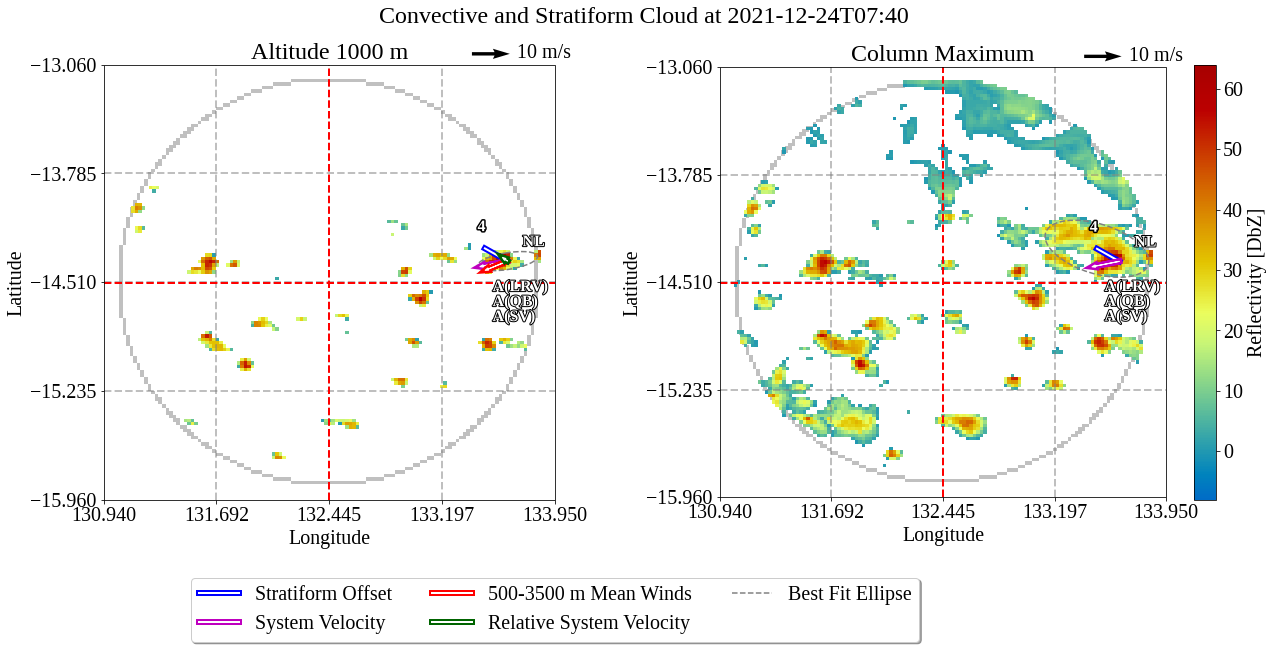

In [38]:
# filename = filenames[12]
# grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])

# ACCESS_refl = tint.process_ACCESS.

current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")

params = {
    'uid_ind': None, 'line_coords': False, 'center_cell': False,
    'cell_ind': 10, 'winds': False,
    'crosshair': True, 'fontsize': 20, 'colorbar_flag': True,
    'leg_loc': 2, 'label_type': 'velocities',
    'system_winds': ['shift', 'ambient_mean', 'relative'],
    'boundary': True, 'exclude': False}

tint.visualisation.figures.two_level(
    tracks_obj, grid, params=params, alt1=0, alt2=1)
plt.savefig(
    fig_dir + '/test_{}.png'.format(current_time), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

In [12]:
era5_all = xr.open_dataset(
    '/home/student.unimelb.edu.au/shorte1/Documents/era5_stuff/adaptor.mars.internal-1655789146.7190747-22014-23-f88f7808-4f1e-4fb9-b292-7e120594efb9.nc')

In [13]:
era5_all.time[-1]

<xarray.DataArray 'time' ()>
array('2022-05-30T23:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-05-30T23:00:00
Attributes:
    long_name:  time

In [18]:
era5_all.z.to_netcdf('/home/student.unimelb.edu.au/shorte1/Documents/era5_stuff/z_era5_oper_pl_20220401-20220430.nc')

In [11]:
era5_all.time

NameError: name 'era5_all' is not defined

> /tmp/ipykernel_25774/2239899693.py(1)<module>()
----> 1 era5_all.time

ipdb> q
